# Benin Electrification Analysis

This notebook runs the least-cost electrification model on Benin settlement data.

Results:
- Technology selection per settlement
- Investment requirements
- Summary statistics and visualizations


In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from benin_least_cost.schema import DataValidator, DataSchema as DS
from benin_least_cost.parameters import ProjectConfig
from benin_least_cost.demand import run_demand_model
from benin_least_cost.lcoe import run_lcoe_model

plt.style.use('seaborn-v0_8-darkgrid')
pd.options.display.float_format = '{:.2f}'.format


## Load Data


In [2]:
gdf = gpd.read_file("../data/settlements.geojson")
gdf = DataValidator.validate_input(gdf)

print(f"Loaded {len(gdf)} settlements")
print(f"Columns: {len(gdf.columns)}")


Loaded 17205 settlements
Columns: 48


## Run Model


In [3]:
config = ProjectConfig()

gdf = run_demand_model(gdf, config)
gdf = run_lcoe_model(gdf, config)

print("Model complete")


Model complete


## Results


In [4]:
tech_counts = gdf[DS.OPTIMAL_TECH].value_counts()
total_inv = gdf[DS.INVESTMENT].sum()
total_demand = gdf[DS.PROJECTED_DEMAND].sum()
total_pop = gdf['population'].sum()

print(f"Total settlements: {len(gdf):,}")
print(f"Total population: {total_pop:,.0f}")
print(f"\nTechnology allocation:")
for tech, count in tech_counts.items():
    pct = 100 * count / len(gdf)
    print(f"  {tech}: {count:,} settlements ({pct:.1f}%)")

print(f"\nProjected annual demand (2040): {total_demand:,.0f} kWh/year")
print(f"Total CAPEX investment: ${total_inv:,.0f}")


Total settlements: 17,205
Total population: 14,111,192

Technology allocation:
  SHS: 8,130 settlements (47.3%)
  MiniGrid: 7,552 settlements (43.9%)
  Grid: 1,523 settlements (8.9%)

Projected annual demand (2040): 2,693,741,583 kWh/year
Total CAPEX investment: $2,263,483,493


In [5]:
investment_by_tech = gdf.groupby(DS.OPTIMAL_TECH)[DS.INVESTMENT].sum()
demand_by_tech = gdf.groupby(DS.OPTIMAL_TECH)[DS.PROJECTED_DEMAND].sum()
pop_by_tech = gdf.groupby(DS.OPTIMAL_TECH)['population'].sum()

lcoe_cols = {'Grid': DS.LCOE_GRID, 'MiniGrid': DS.LCOE_MG, 'SHS': DS.LCOE_SHS}
lcoe_avgs = [gdf[gdf[DS.OPTIMAL_TECH]==t][lcoe_cols[t]].mean() for t in ['Grid', 'MiniGrid', 'SHS']]

summary = pd.DataFrame({
    'Settlements': tech_counts,
    'Population': pop_by_tech,
    'Demand_GWh': demand_by_tech / 1e6,
    'Investment_M': investment_by_tech / 1e6,
    'Investment_per_capita': investment_by_tech / pop_by_tech,
    'LCOE_avg': lcoe_avgs
})

summary


,Settlements,Population,Demand_GWh,Investment_M,Investment_per_capita,LCOE_avg
optimal_tech,,,,,,
Grid,1523,11477544,2532.49,1575.45,137.26,0.38
MiniGrid,7552,2131065,146.90,674.95,316.72,0.80
SHS,8130,502583,14.35,13.09,26.04,0.63


## Spatial Distribution


C:\Users\badra\AppData\Local\Temp\ipykernel_16360\3871062811.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title='Technology', loc='upper right')
C:\Users\badra\AppData\Local\Temp\ipykernel_16360\3871062811.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Technology', loc='upper right')


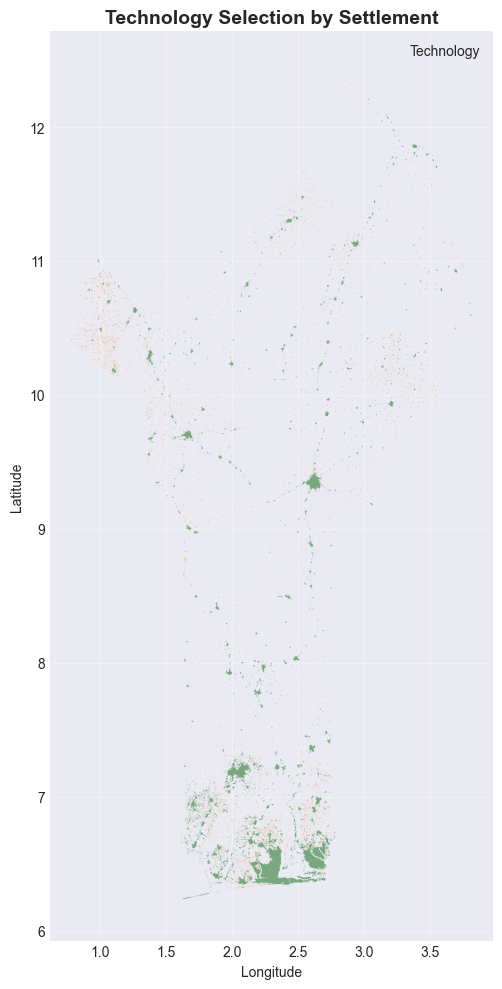

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))

colors = {'Grid': '#2E7D32', 'MiniGrid': '#F57C00', 'SHS': '#FDD835'}
for tech in ['Grid', 'MiniGrid', 'SHS']:
    subset = gdf[gdf[DS.OPTIMAL_TECH] == tech]
    subset.plot(ax=ax, color=colors[tech], markersize=1, alpha=0.6, label=tech)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Technology Selection by Settlement', fontsize=14, fontweight='bold')
ax.legend(title='Technology', loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
## Economic Analysis


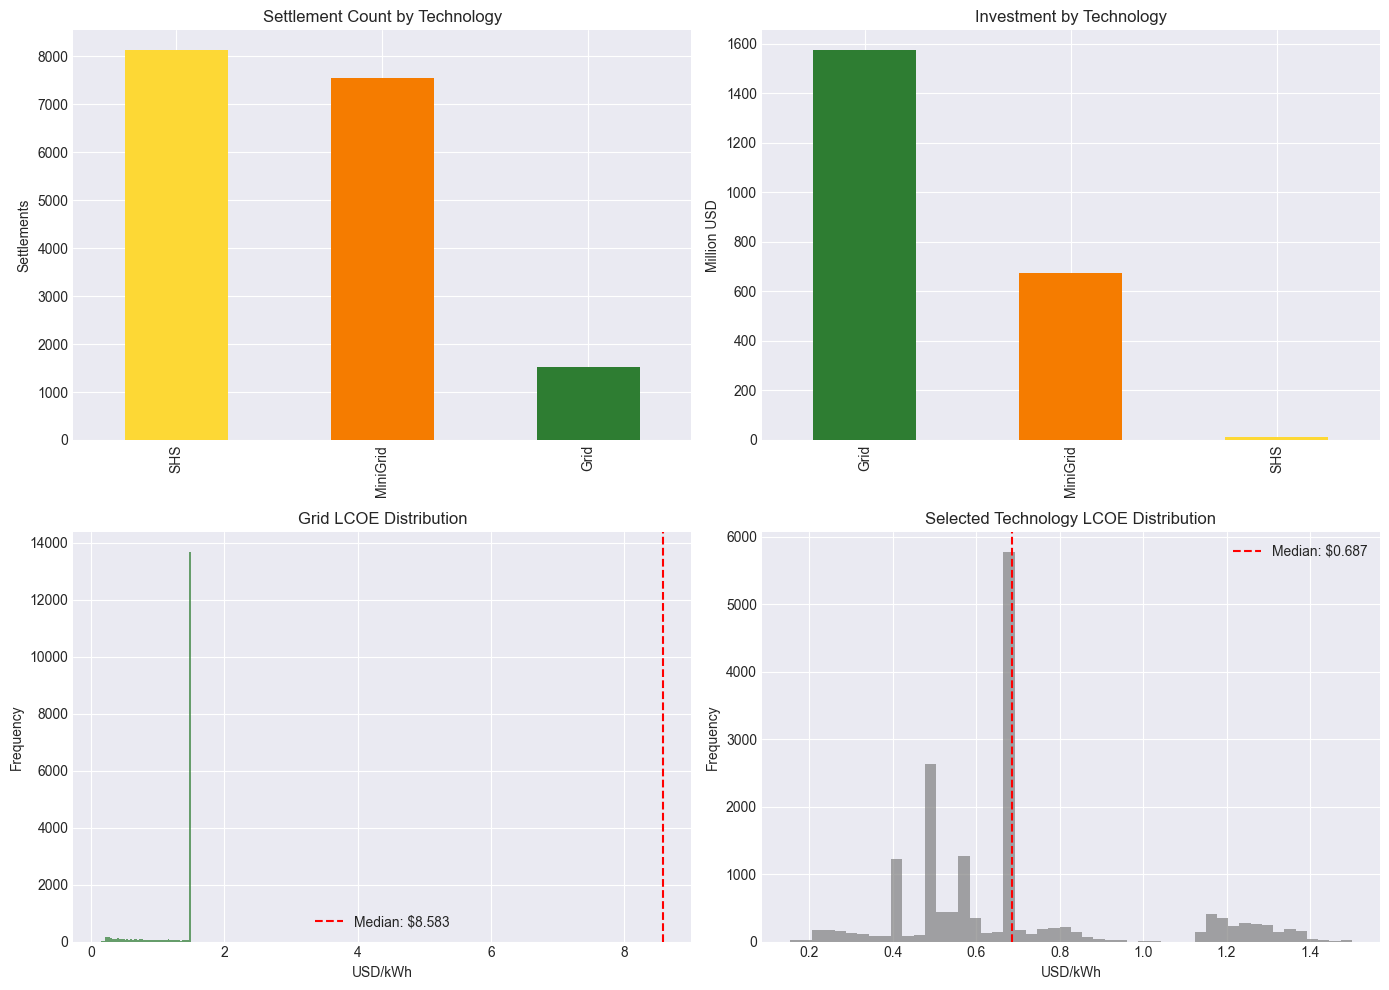

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

tech_counts.plot(kind='bar', ax=axes[0,0], color=[colors[t] for t in tech_counts.index])
axes[0,0].set_title('Settlement Count by Technology')
axes[0,0].set_ylabel('Settlements')
axes[0,0].set_xlabel('')

(investment_by_tech / 1e6).plot(kind='bar', ax=axes[0,1], color=[colors[t] for t in investment_by_tech.index])
axes[0,1].set_title('Investment by Technology')
axes[0,1].set_ylabel('Million USD')
axes[0,1].set_xlabel('')

for ax, col, title in zip([axes[1,0]], [DS.LCOE_GRID], ['Grid LCOE Distribution']):
    gdf[col].clip(upper=1.5).hist(bins=50, ax=ax, color=colors['Grid'], alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('USD/kWh')
    ax.set_ylabel('Frequency')
    ax.axvline(gdf[col].median(), color='red', linestyle='--', label=f'Median: ${gdf[col].median():.3f}')
    ax.legend()

lcoe_selected = []
for idx, row in gdf.iterrows():
    tech = row[DS.OPTIMAL_TECH]
    if tech == 'Grid':
        lcoe_selected.append(row[DS.LCOE_GRID])
    elif tech == 'MiniGrid':
        lcoe_selected.append(row[DS.LCOE_MG])
    else:
        lcoe_selected.append(row[DS.LCOE_SHS])

pd.Series(lcoe_selected).clip(upper=1.5).hist(bins=50, ax=axes[1,1], color='gray', alpha=0.7)
axes[1,1].set_title('Selected Technology LCOE Distribution')
axes[1,1].set_xlabel('USD/kWh')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(np.median(lcoe_selected), color='red', linestyle='--', label=f'Median: ${np.median(lcoe_selected):.3f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()


## Demand Characteristics


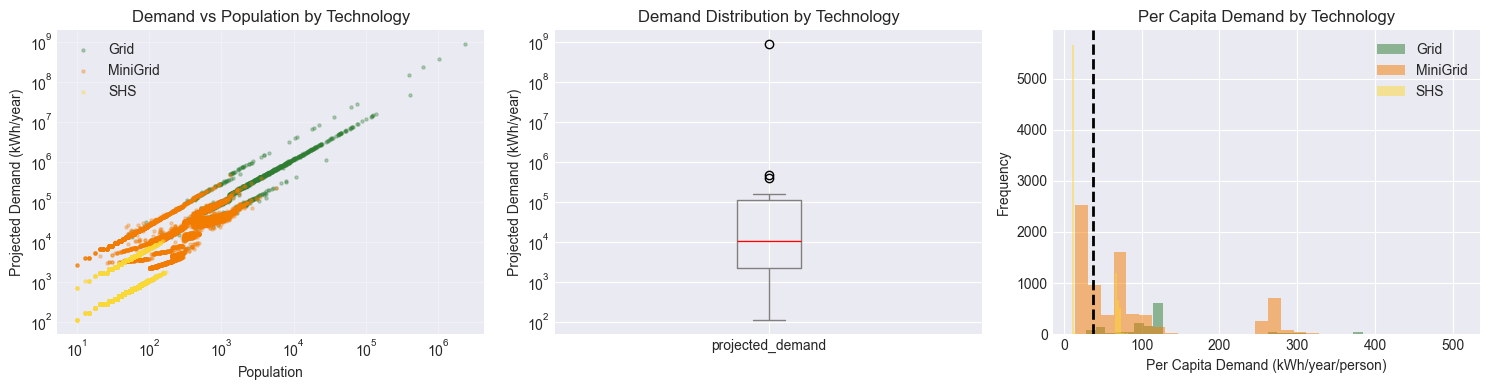

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for tech, color in colors.items():
    subset = gdf[gdf[DS.OPTIMAL_TECH] == tech]
    axes[0].scatter(subset['population'], subset[DS.PROJECTED_DEMAND], 
                    alpha=0.3, s=5, label=tech, color=color)
axes[0].set_xlabel('Population')
axes[0].set_ylabel('Projected Demand (kWh/year)')
axes[0].set_title('Demand vs Population by Technology')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

gdf.groupby(DS.OPTIMAL_TECH)[DS.PROJECTED_DEMAND].apply(
    lambda x: pd.Series([x.min(), x.quantile(0.25), x.median(), x.quantile(0.75), x.max()])
).T.plot(kind='box', ax=axes[1], color=dict(boxes='gray', whiskers='gray', medians='red', caps='gray'))
axes[1].set_ylabel('Projected Demand (kWh/year)')
axes[1].set_title('Demand Distribution by Technology')
axes[1].set_yscale('log')

per_capita_demand = gdf[DS.PROJECTED_DEMAND] / gdf['population']
for tech, color in colors.items():
    subset = per_capita_demand[gdf[DS.OPTIMAL_TECH] == tech]
    axes[2].hist(subset.clip(upper=2000), bins=30, alpha=0.5, label=tech, color=color)
axes[2].set_xlabel('Per Capita Demand (kWh/year/person)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Per Capita Demand by Technology')
axes[2].legend()
axes[2].axvline(per_capita_demand.median(), color='black', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()


## Technology Competitiveness


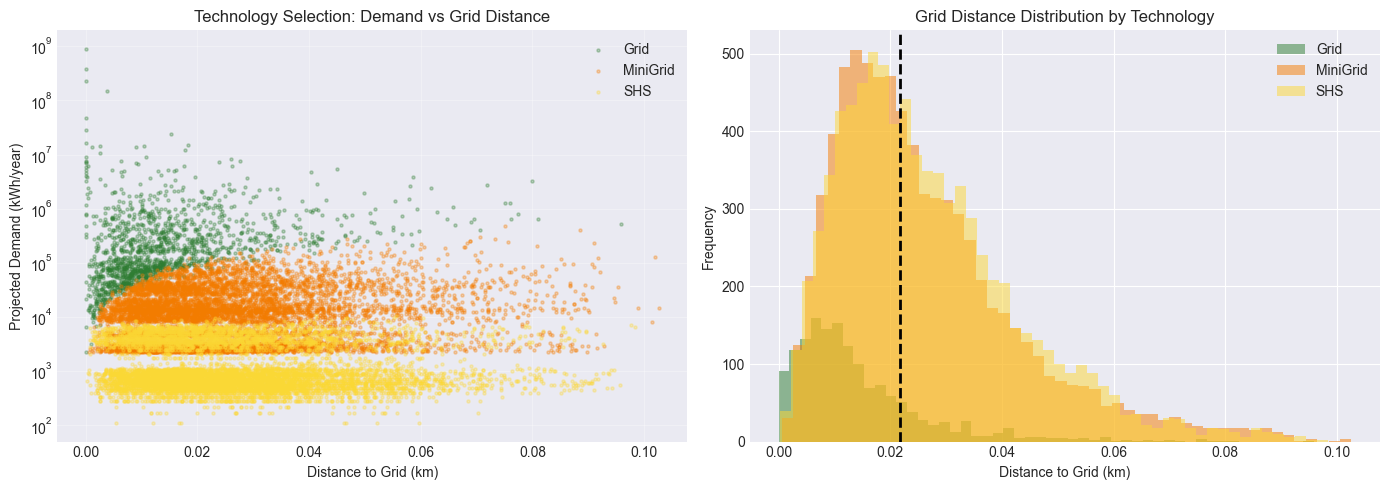

Median grid distance by technology:
  Grid: 0.0 km
  MiniGrid: 0.0 km
  SHS: 0.0 km


In [10]:
grid_dist_col = 'dist_to_substations' if 'dist_to_substations' in gdf.columns else None

if grid_dist_col:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for tech, color in colors.items():
        subset = gdf[gdf[DS.OPTIMAL_TECH] == tech]
        axes[0].scatter(subset[grid_dist_col]/1000, subset[DS.PROJECTED_DEMAND], 
                        alpha=0.3, s=5, label=tech, color=color)
    axes[0].set_xlabel('Distance to Grid (km)')
    axes[0].set_ylabel('Projected Demand (kWh/year)')
    axes[0].set_title('Technology Selection: Demand vs Grid Distance')
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    for tech, color in colors.items():
        subset = gdf[gdf[DS.OPTIMAL_TECH] == tech]
        axes[1].hist(subset[grid_dist_col]/1000, bins=50, alpha=0.5, label=tech, color=color)
    axes[1].set_xlabel('Distance to Grid (km)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Grid Distance Distribution by Technology')
    axes[1].legend()
    axes[1].axvline(gdf[grid_dist_col].median()/1000, color='black', linestyle='--', linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Median grid distance by technology:")
    for tech in ['Grid', 'MiniGrid', 'SHS']:
        median_dist = gdf[gdf[DS.OPTIMAL_TECH]==tech][grid_dist_col].median() / 1000
        print(f"  {tech}: {median_dist:.1f} km")
else:
    print("Grid distance data not available")


## Key Insights


In [11]:
insights = []

pct_grid = 100 * tech_counts['Grid'] / len(gdf)
pct_mg = 100 * tech_counts['MiniGrid'] / len(gdf)
pct_shs = 100 * tech_counts['SHS'] / len(gdf)

insights.append(f"1. Technology allocation: Grid extension serves only {pct_grid:.1f}% of settlements, "
                f"while decentralized solutions (Mini-Grid: {pct_mg:.1f}%, SHS: {pct_shs:.1f}%) dominate.")

inv_pct_grid = 100 * investment_by_tech['Grid'] / total_inv
inv_pct_mg = 100 * investment_by_tech['MiniGrid'] / total_inv
inv_pct_shs = 100 * investment_by_tech['SHS'] / total_inv

insights.append(f"2. Investment allocation: Grid requires {inv_pct_grid:.1f}% of total CAPEX, "
                f"Mini-Grid {inv_pct_mg:.1f}%, SHS {inv_pct_shs:.1f}%.")

demand_pct_grid = 100 * demand_by_tech['Grid'] / total_demand
demand_pct_mg = 100 * demand_by_tech['MiniGrid'] / total_demand
demand_pct_shs = 100 * demand_by_tech['SHS'] / total_demand

insights.append(f"3. Demand served: Grid serves {demand_pct_grid:.1f}% of total projected demand, "
                f"Mini-Grid {demand_pct_mg:.1f}%, SHS {demand_pct_shs:.1f}%.")

avg_lcoe_grid = gdf[gdf[DS.OPTIMAL_TECH]=='Grid'][DS.LCOE_GRID].mean()
avg_lcoe_mg = gdf[gdf[DS.OPTIMAL_TECH]=='MiniGrid'][DS.LCOE_MG].mean()
avg_lcoe_shs = gdf[gdf[DS.OPTIMAL_TECH]=='SHS'][DS.LCOE_SHS].mean()

insights.append(f"4. Average LCOE for selected technology: Grid ${avg_lcoe_grid:.3f}/kWh, "
                f"Mini-Grid ${avg_lcoe_mg:.3f}/kWh, SHS ${avg_lcoe_shs:.3f}/kWh.")

avg_pop_grid = pop_by_tech['Grid'] / tech_counts['Grid']
avg_pop_mg = pop_by_tech['MiniGrid'] / tech_counts['MiniGrid']
avg_pop_shs = pop_by_tech['SHS'] / tech_counts['SHS']

insights.append(f"5. Average settlement size: Grid {avg_pop_grid:.0f} people, "
                f"Mini-Grid {avg_pop_mg:.0f} people, SHS {avg_pop_shs:.0f} people.")

for i, insight in enumerate(insights, 1):
    print(insight)
    print()


1. Technology allocation: Grid extension serves only 8.9% of settlements, while decentralized solutions (Mini-Grid: 43.9%, SHS: 47.3%) dominate.

2. Investment allocation: Grid requires 69.6% of total CAPEX, Mini-Grid 29.8%, SHS 0.6%.

3. Demand served: Grid serves 94.0% of total projected demand, Mini-Grid 5.5%, SHS 0.5%.

4. Average LCOE for selected technology: Grid $0.376/kWh, Mini-Grid $0.804/kWh, SHS $0.631/kWh.

5. Average settlement size: Grid 7536 people, Mini-Grid 282 people, SHS 62 people.



## Save Results


In [12]:
output_path = Path("../results.geojson")
gdf.to_file(output_path, driver="GeoJSON")
print(f"Saved to {output_path}")


Saved to ..\results.geojson
